In [482]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


In [483]:
train_df = pd.read_csv('data/flight_delays_train.csv')
test_df = pd.read_csv('data/flight_delays_test.csv')

In [484]:
train_df.shape

(100000, 9)

In [485]:
test_df.shape

(100000, 8)

In [486]:
train_df['dep_delayed_15min'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
y = train_df['dep_delayed_15min']
idx_split = train_df.shape[0]

In [487]:
train_df.groupby(['DayOfWeek']).agg({'dep_delayed_15min': np.sum}).sort_values(('dep_delayed_15min'), ascending=False)

,dep_delayed_15min
DayOfWeek,
c-5,3285
c-4,3117
c-1,2774
c-7,2705
c-3,2567
c-2,2451
c-6,2145


In [489]:
train_df.groupby(['Origin']).agg({'dep_delayed_15min': np.sum}).sort_values(('dep_delayed_15min'), ascending=False).head()

,dep_delayed_15min
Origin,
ATL,1506
ORD,1254
DFW,902
DEN,575
LAX,552


In [490]:
train_df.groupby(['Dest']).agg({'dep_delayed_15min': np.sum}).sort_values(('dep_delayed_15min'), ascending=False).head()

,dep_delayed_15min
Dest,
ATL,1281
ORD,1072
DFW,656
EWR,584
LAX,525


In [512]:
train_df.groupby(['Month']).agg({'dep_delayed_15min': np.sum}).sort_values(('dep_delayed_15min'), ascending=False)

,dep_delayed_15min
Month,
7,2073
12,1994
6,1867
8,1783
3,1676
1,1539
10,1501
11,1397
2,1316


In [452]:
full_df = pd.concat([train_df.drop('dep_delayed_15min', axis=1), test_df])
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


In [453]:
idx_split

100000

In [454]:
#full_df['flight']=full_df['Origin']+'-'+full_df['Dest']

In [455]:
#full_df = full_df.drop(columns=['Origin','Dest'])
#test_df = test_df.drop(columns=['Origin','Dest'])

In [456]:
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


In [457]:
origin_list = full_df.Origin.value_counts().index.tolist()
odf = pd.DataFrame(origin_list)
odf = odf.drop_duplicates()
origin_list = odf[0].head(30).tolist()

In [458]:
dest_list = full_df.Dest.value_counts().index.tolist()
ddf = pd.DataFrame(dest_list)
ddf = ddf.drop_duplicates()
dest_list = ddf[0].head(30).tolist()

In [459]:
carriers_list = full_df.UniqueCarrier.value_counts().index.tolist()
cl = pd.DataFrame(carriers_list)
cl = cl.drop_duplicates()
carriers_list = cl[0].head(15).tolist()
len(carriers_list)

15

In [460]:
full_df['DayOfWeek'] = full_df.DayOfWeek.apply(lambda x: int(x.split('-')[1]))
full_df['Month'] = full_df.Month.apply(lambda x: int(x.split('-')[1]))
full_df['DayofMonth'] = full_df.DayofMonth.apply(lambda x: int(x.split('-')[1]))
full_df['Origin'] = full_df.Origin.apply(lambda x: x if x in origin_list else 'other')
full_df['Dest'] = full_df.Dest.apply(lambda x: x if x in dest_list else 'other')
full_df['UniqueCarrier'] = full_df.UniqueCarrier.apply(lambda x: x if x in carriers_list else 'other')

In [461]:
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,8,21,7,1934,AA,ATL,DFW,732
1,4,20,3,1548,US,other,MCO,834
2,9,2,5,1422,XE,other,CLE,416
3,11,25,6,1015,OO,DEN,other,872
4,10,7,6,1828,WN,MDW,other,423


In [462]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1


In [513]:
full_df['thursday'] = full_df['DayOfWeek'].map(lambda x: x==5)
full_df['July'] = full_df['Month'].map(lambda x: x==7)
full_df['bad_origin'] = full_df['Origin'].apply(lambda x: x=='ATL'or x=='ORD')
full_df['bad_dest'] = full_df['Dest'].apply(lambda x: x=='ATL'or x=='ORD')

In [514]:
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,thursday,bad_dest,bad_origin,July
0,8,21,7,1934,AA,ATL,DFW,732,False,False,True,False
1,4,20,3,1548,US,other,MCO,834,False,False,False,False
2,9,2,5,1422,XE,other,CLE,416,True,False,False,False
3,11,25,6,1015,OO,DEN,other,872,False,False,False,False
4,10,7,6,1828,WN,MDW,other,423,False,False,False,False


In [515]:
train_df = full_df[0:idx_split]
test_df = full_df[idx_split:full_df.shape[0]]
train_df['dep_delayed_15min'] = y
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,thursday,bad_dest,bad_origin,July,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,False,False,True,False,0
1,4,20,3,1548,US,other,MCO,834,False,False,False,False,0
2,9,2,5,1422,XE,other,CLE,416,True,False,False,False,0
3,11,25,6,1015,OO,DEN,other,872,False,False,False,False,0
4,10,7,6,1828,WN,MDW,other,423,False,False,False,False,1


In [516]:
train_df['Origin'].nunique(), test_df['Origin'].nunique()

(31, 31)

In [517]:
train_df['Dest'].nunique(), test_df['Dest'].nunique()

(31, 31)

In [518]:
train_df['UniqueCarrier'].nunique(), test_df['UniqueCarrier'].nunique()

(16, 16)

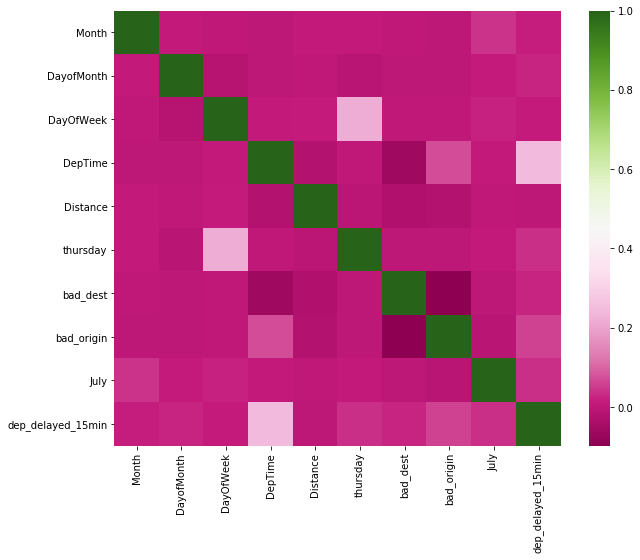

In [519]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), cmap="PiYG");

In [520]:
X_train = pd.get_dummies(train_df)
X_test = pd.get_dummies(test_df)
y_train = X_train['dep_delayed_15min'] 
X_train = X_train.drop(columns=['dep_delayed_15min'])

In [521]:
X_test.shape, X_train.shape

((100000, 87), (100000, 87))

In [522]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.2, random_state=17)

In [523]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, StratifiedKFold
time_split = TimeSeriesSplit(n_splits=10)

In [524]:
lgbm = LGBMClassifier(random_state=17, n_estimators=1000, colsample_bytree=0.66,
                       max_depth=-1, num_leaves=5, reg_alpha=1.2, subsample=0.75,
                       reg_lambda=1, learning_rate=0.5)
lgbm.fit(X_train_part, y_train_part)
lgbm_valid_pred = lgbm.predict_proba(X_valid)[:, 1]

print(roc_auc_score(y_valid, lgbm_valid_pred))

0.7438847692101582


In [525]:
cv_scores = cross_val_score(lgbm, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)
print('CV scores', cv_scores)
print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    

CV scores [0.69378462 0.7019079  0.72092431 0.73044127 0.73366682 0.73971109
 0.72574865 0.74040298 0.75377116 0.7460104 ]
CV mean: 0.7286369204822573, CV std: 0.017944777972292415


In [526]:
lgbm.fit(X_train, y_train)
test_pred = lgbm.predict_proba(X_test)[:, 1]

pd.Series(test_pred, 
          name='dep_delayed_15min').to_csv('lgbm.csv', 
                                           index_label='id', header=True)

xgb = XGBClassifier(seed=17)
parameters = {'num_leaves': [3, 7, 15, 31, 63, 127],
              'max_depth': [3, 4, 5, 6, 7]}
grid_search = GridSearchCV(estimator=xgb, param_grid=parameters, 
                           verbose=1, scoring='roc_auc',
                           n_jobs=4, cv=time_split)
grid_search = grid_search.fit(X_train, y_train)

grid_search.best_params_, grid_search.best_score_

In [542]:
xgb2 = XGBClassifier(seed=17,max_depth=6, num_leaves=3, n_estimators=500)
xgb2.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb2.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.7518097436323983

In [543]:
cv_scores = cross_val_score(xgb2, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)
print('CV scores', cv_scores)
print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    

CV scores [0.69967708 0.7110424  0.72694569 0.73908503 0.7373831  0.74680406
 0.73427025 0.74639255 0.76282702 0.75650404]
CV mean: 0.7360931225450476, CV std: 0.018448277031695867


In [544]:
xgb2.fit(X_train, y_train)
test_pred = xgb2.predict_proba(X_test)[:, 1]

pd.Series(test_pred, 
          name='dep_delayed_15min').to_csv('xgb_2.csv', 
                                           index_label='id', header=True)

## LB Score of 0.73564 - yahoooooo!!!